In [124]:
from __future__ import annotations


import numpy as np
from numpy import float64 as F
from numpy import complex128 as Comp
import copy
import math
from enum import Enum

In [125]:
# utils

def random_input_channel(dim: int):
    return np.random.randint(low=0, high=256, size=(dim, dim), dtype=F)

def random_kernal(dim: int):
    return np.random.randint(low=0, high=256, size=(dim, dim), dtype=F)

# ----
def negacylic_mul(a: [F], b:[F]) -> [F]:
    assert len(a) == len(b)

    ring_size = len(a)
    c = np.zeros(shape=ring_size, dtype=F)
    for i in range(ring_size):
        for j in range(0, i+1):
            c[i] += a[j] * b[i - j]
        for j in range(0, ring_size-(i+1)):
            c[i] -= a[j+i+1] * b[ring_size - 1 - j]
    return c.tolist()

def add_poly(a: [F], b: [F]) -> [F]:
    ring_size = len(a)
    assert len(b) == ring_size

    c = np.zeros(shape=ring_size, dtype=F).tolist()
    for i in range(ring_size):
        c[i] = a[i] + b[i]
    return c 

def elwise_mul(a:[F], b:[F]) -> [F]:
    assert len(a) == len(b)
    return [ai*bi for ai,bi in zip(a, b)]

def bit_reverse_value(value, num_bits) -> int:
    result = 0
    for _ in range(num_bits):
        result = (result << 1) | (value & 1)
        value >>= 1
    return result

def get_bit_reverse_array(a: [Comp], n:int) -> [Comp]:
    r = [Comp(0) for i in range(0,n)]
    logn = int(math.log2(n))
    for i in range(0 , n):
        bit_reverse_i = bit_reverse_value(i, logn)
        r[bit_reverse_i] = a[i]

    return r

def precision_stats(values: [F], wants:[F]):
    '''
    Prints max/mean precision of `values` compared to ideal values `wants`
    '''
    
    assert len(values) == len(wants)

    logmax = -99999
    logmean = 0
    
    for (a,b) in zip(values, wants):
        diff = a-b
        logdiff = -np.log2(abs(diff))

        logmean += logdiff

        if logmax < logdiff:
            logmax = logdiff

    logmean = logmean/len(values)
    
    print(f'''
     ---------------
    |PRECISION STATS|
     ---------------
        Values  : {values[:min(len(values), 3)]}
        Wants   : {wants[:min(len(values), 3)]}

        Max : {logmax}
        Mean: {logmean}
        
    ''')
    

# CKKS
 
Instead of starting with CKKS ciphertect I would like to tell you something about CKKS plaintext because it is easier to think in terms of operations over plaintext instead of starting with the ciphertext. CKKS plaintext has rich structure and once one has ideas about how to best evaluate a function using APIs available to the plaintext, one can then easily port it over for ciphertexts. After which the only hard part pending is figuring out secure parameters (for ex, $\lambda$ = 128 etc.) and where to insert rescaling procedures. 

# CKKS Plaintext

CKKS Plaintext is a polynomial in ring $R/(X^N+1)$ (i.e. any polynomial with real coeffcieints and degree < N and N a power of 2). 

For ex, if ring is $R/X^8 + 1$ then following polynomial is a plaintext

$$0.12 + 0.42x + 0.23x^2 + 0.56x^3 + 0.43x^4 + 1.23x^5 + 1.78x^6 + 3.45x^7$$

$X^N+1$ is the modulo. So one can take any polynomial with real coefficients and reduce it by X^N+1 to find representation of the polynomial in the ring $R/X^N+1$. 

Reduction is simple if one observes that $X^N \mod{X^N+1} = -1$. Hence, to reduce a polynomial of degree >= N by $\mod X^N+1$, one can simply replace $X^N$ with -1. 

For example,

$$0.12 + 0.42x + 0.23x^2 + 0.56x^3 + 0.43x^4 + 1.23x^5 + 1.78x^6 + 3.45x^7 + 4.56x^8 \mod{X^N+1}$$
$$0.12 + 0.42x + 0.23x^2 + 0.56x^3 + 0.43x^4 + 1.23x^5 + 1.78x^6 + 3.45x^7 - 4.56 \mod{X^N+1}$$
$$0.12 - 4.56 + 0.42x + 0.23x^2 + 0.56x^3 + 0.43x^4 + 1.23x^5 + 1.78x^6 + 3.45x^7 \mod{X^N+1}$$ 


The fact that terms with degree >=N wrap around and negate is usually referred to as negacylic property. 

## Negacylic multplication

If we were to multiply two polynomial $Y, Z \in R$, we will observe that terms wrap around and become -ve (ie. negacylic). 

In [126]:
def negacylic_mul(a: [F], b:[F]) -> [F]:
    '''
    Returns a*b
    
    - a, b \in R
    '''
    
    assert len(a) == len(b)

    ring_size = len(a)
    c = np.zeros(shape=ring_size, dtype=F)
    for i in range(ring_size):
        for j in range(0, i+1):
            c[i] += a[j] * b[i - j]
        for j in range(0, ring_size-(i+1)):
            c[i] -= a[j+i+1] * b[ring_size - 1 - j]
    return c

We can multiply polynomials in $R$, which infact results in negacylic multiplication. More so we can add and subtract two polynomials in $R$. 

## Coefficient encoding 

If were to let CKKS plaintext be a polynomial in $R$, then we will have access to negacylic multiplication, addtion, and subtraction. We usually refer to this as **Coefficient encoding**. 

## SIMD encoding

Turns out structure of ring $R$ is quite rich and we can store a vector of real values as a polynomial in ring such that operations over polynomails correspond to elementwise operations over the vectors, aka **SIMD encoding**. 

For ex,

given vector 

$$a = [a0, a1, a2, a3]$$ 
$$b = [b0, b1, b2, b3]$$

we can encode vectors $a,b$ as polynomials $A,B$ in ring $R$ such that $A*B$ (i.e. polynomial multiplication) corresponds to elementwise multiplication of $a$ and $b$ (same applies for +/-)



How to do SIMD encoding? 

Not important to mention but just in case someone is interested. 

In [127]:
def find_mth_root_of_unity(M: int) -> Comp:
    '''
    Returns M^th primitive root of unity
    '''
    zeta = np.exp(Comp(2 * math.pi * 1j)/Comp(M))
    return zeta

def get_psi_powers(M: int) -> [Comp]:
    '''
    Returns powers of \psi
        [1, \psi, \psi^2, ..., \psi^{M-1}]
    '''
    
    # M^th primitive root of unity
    psi = find_mth_root_of_unity(M)
    
    # powers of M^th primitive root of unity
    psi_powers = []
    for i in range(0, M):
        psi_powers.append(psi ** i)

    return psi_powers

def get_rot_group(N_half: int, M: int) -> [int]:
    p = 1
    rot_group =[]
    for i in range(0, N_half):
        rot_group.append(p)
        p *= 5
        p %= M

    return rot_group

def specialIFFT(a: [Comp]) -> [Comp]:
    a = copy.deepcopy(a)
    
    N_half = len(a)
    N = N_half << 1
    M = N << 1

    length_n = N_half
    psi_powers = get_psi_powers(M)
    rot_group = get_rot_group(N_half, M)
    
    while length_n >= 1:
        for i in range(0, N_half, +length_n):
            lenh = length_n >> 1
            lenq = length_n << 2
            gap = M // lenq
            for j in range(0, lenh):
                idx = (lenq -( rot_group[j] % lenq)) * gap
                u = a[i+j] + a[i+j+lenh]
                v = a[i+j] - a[i+j+lenh]
                v = v * psi_powers[idx]
                a[i+j] = u
                a[i+j+lenh] = v

        length_n >>= 1

    a = get_bit_reverse_array(a, N_half)

    # multiply by 1/n and return
    return [i/Comp(N_half) for i in a]

def specialFFT(a: [Comp]) -> [Comp]:
    N_half = len(a) 
    N = N_half << 1
    M = N << 1

    a = get_bit_reverse_array(a, N_half)
    psi_powers = get_psi_powers(M)
    rot_group = get_rot_group(N_half, M)

    length_n = 2
    while length_n <= N_half:
        for i in range(0, N_half, +length_n):
            lenh = length_n >> 1
            lenq = length_n << 2
            gap = M // lenq
            for j in range(0, lenh, +1):
                idx = (rot_group[j] % lenq) * gap
                u = a[i + j]
                v = a[i + j + lenh]
                v *= psi_powers[idx]
                a[i+j] = u + v
                a[i+j+lenh] = u-v

        length_n *= 2

    return a

def simd_encode_complex(a:[C]) -> [F] :
    '''
    SIMD encode vector in C^{N/2} into polynomial R/X^N+1
    '''
    N_half = len(a)
    
    tmp = specialIFFT(a)
    out = []
    for i in range(N_half):
        out.append(F(tmp[i].real))
    for i in range(N_half):
        out.append(F(tmp[i].imag))
    return out


def simd_encode(a:[F]) -> [F] :
    '''
    SIMD encode vector in R^{N/2} into polynomial R/X^N+1
    '''
    N_half = len(a)
    
    a_comp = [Comp(i) for i in a]
    
    return simd_encode_complex(a_comp)

def simd_decode(a: [F]) -> [F]:
    '''
    SIMD decode polynomial in R/X^N+1 to vector C^{N/2}
    '''
    N_half = len(a)//2
    tmp = [Comp(0) for _ in range(N_half)]
    for i in range(N_half):
        tmp[i] = Comp(a[i] + a[i+N_half]*1j)
    out = specialFFT(tmp)
    
    out_float = [F(i.real) for i in out]
    
    return out_float

a = np.random.rand(8).tolist()
b = np.random.rand(8).tolist()

A = simd_encode(a)
B = simd_encode(b)

C = negacylic_mul(A, B)
c = elwise_mul(a, b)

c_back = simd_decode(C)
precision_stats(c_back , c)



     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [0.07261994262105773, 0.1479672167720324, 0.5961009527631411]
        Wants   : [0.07261994262105746, 0.14796721677203217, 0.5961009527631419]

        Max : inf
        Mean: inf
        
    


/var/folders/0j/nn6_632s7b7bwdg71rbtjpcr0000gn/T/ipykernel_10933/4294523121.py:63: RuntimeWarning: divide by zero encountered in log2
  logdiff = -np.log2(abs(diff))


### Rotations

In SIMD encoding one can rotate the encoded vectors. For ex,

Given vector 

a = [a0 , a1, a2, a3, a4, a5, a6, a7] 

encoded as $A \in R$ 

A = `simd_encode(a)`

We can modify A s.t. a, the vector, is rotated either left/right. 


<!-- One key thing to note for rotations it is better to view encoded vector as a matrix of $2 \times (n/2)$ where n is the vector length. 
 -->
 
For ex, 

$$a = [a0 , a1, a2, a3, a4, a5, a6, a7]$$

<!-- then for rotations we should view vector $a$ as 2d matrix:

$$\begin{array} \\
a0 & a1 & a2 & a3 \\
a4 & a5 & a6 & a7 \\
\end{array}$$
 -->

rotation to the left by 1 outputs
$$[a1, a2, a3, a4, a5, a6, a7, a0]$$

<!-- We can also swap the rows

$$\begin{array} \\
a4 & a5 & a6 & a7 \\
a0 & a1 & a2 & a3 \\
\end{array}$$
 -->

How do rotations works intervally? 

TODO

In [128]:
def substitute_poly(input: [F], s: int) -> [F]:
    '''
    Sends input polynomial F(X) to F(X^s)
    '''
    if s == 1:
        return input
    
    ring_size = len(input)

    output = [F(0) for _ in range(ring_size)]
    
    for i in range(ring_size):
        exp = (i*s) % (2*ring_size)
        if exp >= ring_size:
            output[exp-ring_size] -= input[i]
        else: 
            output[exp] += input[i]

    return output

def rotate_simd_ring_poly(a: [F], by: int) -> [F]:
    '''
    Rotates simd encoded ring polynomial either left or right by `by` elements. 
    
    Rotation is clockwise if `by` is +, other anti-clockwise
    '''
    
    N = len(a)
    N_half = N//2
    M = 2*N
    
    # 5 is generator for group Z*_{M}
    g = 5
    
    k = pow(5, by, M)
    return substitute_poly(a, k)
    
    

In [129]:
a = np.random.rand(8).tolist()
A = simd_encode(a)

A_r = rotate_simd_ring_poly(A, 3)
a_r = a[3:] + a[:3]

precision_stats(simd_decode(A_r), a_r)


     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [0.22227528750029443, 0.6104693276719454, 0.6662687909692449]
        Wants   : [0.22227528750029424, 0.6104693276719457, 0.6662687909692452]

        Max : inf
        Mean: inf
        
    


/var/folders/0j/nn6_632s7b7bwdg71rbtjpcr0000gn/T/ipykernel_10933/4294523121.py:63: RuntimeWarning: divide by zero encountered in log2
  logdiff = -np.log2(abs(diff))


# CKKS Ciphertexts

One can think of CKKS ciphertext inside which we simply fit (encoded) CKKS plaintext polynomial. After which operations over the ciphertext transalte to same operations over the plaintext. 


## Ring learning with errors

Before I can tell you anything about CKKS encryption, I will have to tell you something about the hardness assumption it relies upon - RLWE.

Let's define $Q$ (a big value) and another ring $R_Q = Z_Q/X^N+1$ (again, polynomial in ring $R_Q$ will have coefficients in in $Z_Q$ and degree < N)


Let secret S be a polynomial $\in R_Q$ with coefficients from ternary distribution {-1, 0, 1}. Sample $A \in R_Q$ and sample error $E \in R_Q$ with coefficients from gaussian distribution.

My claim is if I give you tuple, 

$$(B = -A*S + E, A)$$

finding $S$ is hard

This is also known as *search variant* of RLWE.


## RLWE and CKKS ciphertext

Assume that Q approximately equals some big power of 2 (for ex, Q = 2^881).

Now given a CKKS plaintext $M \in R$ (recall $R = R/X^N+1$) we first scale $M$ by $\Delta$ to output $\Delta M$. $\Delta$ defines the precision of CKKS plaintext (for ex, if $\Delta = 2^{40}$, then the plaintext has 40 bits of precision) 

Then we convert $\Delta M$ from signed interval, $Z$, to unsigned interval in $Z_Q$ and add $M$ to $-A*S + E$. We set ciphertext as tuple
$$B = -A*S + E + \Delta M, A$$

Notice that $\Delta M$ cleanly avoids getting jumbled up with E, since coefficients of E are sampled from gaussian distribution, and are small in value. 

In [130]:
# # For ex, 

# # 40 bits precision
# delta = 2**40
# # 2**881
# Q = 21830128391083190

# m = [1.23, .23, 42.43, 13.32]
# M = simd_encode(m)
# delta_M = delta * M

# A = [[]]
# S = [[]]
# E = [[]]

# B = -A*S+E

# ct = CkksCiphertext(B, A)

# CKKS ciphertext operations

### Note on decryption structure:
    
Given ciphertext $ct0 = (C00, C01)$, encrypting message polynomial $M0$, we define its decryption structure as

$$C00 + C01*S$$

where $S$ is the secret polynomial. 

The decryption structure equals $\Delta M0$ with some error

$$\Delta M0 + E0$$


### Addition/Subtraction

Given two ciphertexts 

$$ct0 = (C00, C01)$$ 
and 
$$ct1 = (C10, C11)$$

Adding 

$$ct0 + ct1 = (C00+C10, C01+C11)$$ 

Outputs $ct2$ s.t. $ct2$'s decryption structure equals 

$$C00+C10 + (C01+C11)*S = \Delta(M0) + E0 + \Delta(M1) + E1 = \Delta(M0+M1) + E0 + E1$$

So addition of ciphertexts outputs a ciphertext with added plaintexts and sighlty increased error $(E0 + E1)$

### Multiplication

Given two ciphertexts 

$$ct0 = (C00, C01)$$
and 
$$ct1 = (C10, C11)$$ 

Multiplication is done via tensoring operation 

$$ct0 * ct1 = (C00*C10, C00*C11+C10*C01, C01C11)$$

Tensoring outputs a ciphertext with the decryption structure:

$$(C00 + C01*S) * (C01 + C11*S) = C00*C10 + (C00*C11 + C10*C01) * S + (C01*C11) S^2$$

So multiplication results in a degree two ciphertext (i.e. requires square of secret polynomial: S^2). 

If we were to multiply two degree 2 ciphertexts, it will result into a degree 4 ciphertext, and so on and so forth. Hence, if we do not reduce the degree resulting ciphertext from 2 back to 1, the degree will grow exponentially.

We reduce a degree 2 ciphertext back to degree 1 via something called re-linearization procedure (or key switching whatever suits you).

It's fancy term that means multiplying $(C01*C11)$ with encryption of $S^2$. For our purposes explaining re-linerization will be a deviation. Hence, I would you to think of it is a blackbox that multiplies $(C01*C11)$ with $S^2$ homomorphically and outputs degree 1 ciphertext.

**What happens to plaintexts in multiplication?**

$$ct0 * ct1 = (\Delta M0 + E0)  * (\Delta M1 + E1) = \Delta^2 M0M1 + \Delta M0E1 + \Delta M2E2 + E0E1$$

So we do get multiplication of $M0$ and $M1$ but with
1. squared scaling factor $\Delta^2$
2. and a lot more noise : $\Delta M0E1 + \Delta M2E2 + E0E1$

To transform resulting ciphertext s.t. its decryption results in $\Delta M0M1 + E$, for some relatively small error $E$, we divide resulting ciphertext by $\Delta$. This is known as rescaling and, for today, I would again like you to think of it as a black box. 

In fact, I would like you think of multiplication operation as consisting of all 3 procedures. 

### Rotations

Recall that rotations only work with SIMD encoding. But internally rotations are translated to simple substitution operations. 

For ex, in the example above, to rotate left by 3, we infact sustituted the plaintext $M(X)$ with $M(X^k)$ where $k = 5^{3} \mod{2N}$ (to know why refer to Rotation section above). 

Now notice that if $M(X)$ is encrypted as 

$$ct0 = (C0(X), C1(X))$$

with decryption structure 

$$C0(X) + C1(X)*S(X) = \Delta M(X) + E(X)$$

then to obtain $M(X^k)$ we can substitute $X^k$ for $X$. That is send

$$C0(X) \to C0(X^k)$$ 

and

$$C1(X) \to C1(X^k)$$ 

Decryption structure resulting ciphertext is 

$$C0(X^k) + C1(X^k)*S(X^k) = \Delta M(X^k) + E(X^k)$$

This results in encryption of $M(X^k)$ under secret $S(X^k)$ and we cannot use it for operations with ciphertexts that are encrypted under $S(X)$. Hence, we need a way to switch back the ciphertext from $S(X^k)$ to $S(X)$. 

This is again a key-switch operation that homomorphically multiplies $C1(X^k)$ with encryptions of $S(X^k)$ and outputs a ciphertext that encrypts $M(X^k)$ under secret key $S(X)$.

Now that we understand that operations over ciphertext literally translate to operations over the plaintext AND ciphertext don't really care about which plaintext encoding one uses, I find it much simpler to write FHE circuits first by just using the plaintexts. Then switch the plaintext types with ciphertext types. After which you can consider yourself halfway through to writing FHE circuits that can be deployed in real-world. The other half is figuring out secure parameters and managing noise growth ~ but I wouldn't focus on them today. 

Which is why for the rest of the workshop I will simply show you how to evaluate different functions leveraging the plaintext space efficiently. 

## Warm Up - Let's calculate cosine distance

**Let's take a concrete example:**

Let's say we have user A and B and want to find out how similar their spending habits are with the caveat that they cannot reveal their private expense data to each other. 

Now if were to it without caring about privacy, then we can categorise their expenditures into categories and assign cummulatative amount spent to each category. Then we can calculate cosine distance between their distribution to find how similar the distributions are. 

For ex, 

User A 

| Categories 	| Cloth 	| Flights 	| Food 	| Sports 	|
|--------|--------|--------|--------|--------|
| Total      	| 100   	| 300     	| 400  	| 500    	|

User B

| Categories 	| Cloth 	| Flights 	| Food 	| Sports 	|
|--------|--------|--------|--------|--------|
| Total      	| 100   	| 300     	| 400  	| 500    	|


Consine distance is defined as

$$
\frac{\sum_i a_i b_i}{\lVert a \rVert \lVert b \rVert}
$$

where 

vector a is distribution of user A
and 
vector b is distribution of user B


We can say that consine distance is simple inner product if we make the following observation

$$
\frac{\sum_i a_i b_i}{\lVert a \rVert \lVert b \rVert} = \sum_i \frac{a_i}{\lVert a \rVert} \frac{b_i}{\lVert b \rVert}
$$


So how can we homomrphically calculate inner products of two vectors encoded as CKKS plaintexts?

### Naive way

Let's just put elements of vectors into the first slots of plaintexts using SIMD encoding and then calculate inner products of the plaintexts

In [142]:
class Encoding(Enum):
    COEFFICIENT = 1
    SIMD = 2

class CkksPlaintext():
    def __init__(self, coeffs: [F], encoding: Encoding):
        self.coeffs = coeffs
        self.encoding = encoding
    
    @staticmethod
    def simd_encode(v: [F]):
        coeffs = simd_encode(a=v)
        return CkksPlaintext(coeffs=coeffs, encoding=Encoding.SIMD)

    @staticmethod
    def simd_encode_complex(v: [Comp]):
        coeffs = simd_encode_complex(a=v)
        return CkksPlaintext(coeffs=coeffs, encoding=Encoding.SIMD)
    
    def simd_encode_broadcast(v: F, vec_size: int):
        ve = [v for _ in range(vec_size)]
        coeffs = simd_encode(a=ve)
        return CkksPlaintext(coeffs=coeffs, encoding=Encoding.SIMD)
    
    @staticmethod
    def coefficient_encode(v: [F]):
        return CkksPlaintext(coeffs=v, encoding=Encoding.COEFFICIENT)
    
    
    def decode(self) -> [F]:
        if self.encoding == Encoding.SIMD:
            return simd_decode(a=self.coeffs)
        else:
            return self.coeffs
        
    def rotate(self, by: int) -> CkksPlaintext:
        assert self.encoding == Encoding.SIMD
        out_coeffs = rotate_simd_ring_poly(a=self.coeffs, by=by)
        return CkksPlaintext(coeffs=out_coeffs, encoding=Encoding.SIMD)
    
    def conjugate(self) -> CkksPlaintext:
        assert self.encoding == Encoding.SIMD
        by = 2*len(self.coeffs)-1 # 2*N - 1
        out_coeffs = rotate_simd_ring_poly(a=self.coeffs, by=by)
        return CkksPlaintext(coeffs=out_coeffs, encoding=Encoding.SIMD)
        
    def __add__(self, rhs: CkksPlaintext) -> CkksPlaintext:
        assert len(self.coeffs) == len(rhs.coeffs)
        assert self.encoding == rhs.encoding
        coeffs_out = [v0+v1 for v0,v1 in zip(self.coeffs, rhs.coeffs)]
        return CkksPlaintext(coeffs=coeffs_out, encoding=self.encoding)

    def __sub__(self, rhs: CkksPlaintext) -> CkksPlaintext:
        assert len(self.coeffs) == len(rhs.coeffs)
        assert self.encoding == rhs.encoding
        coeffs_out = [v0-v1 for v0,v1 in zip(self.coeffs, rhs.coeffs)]
        return CkksPlaintext(coeffs=coeffs_out, encoding=self.encoding)
    
    def __mul__(self, rhs: CkksPlaintext) -> CkksPlaintext:
        assert len(self.coeffs) == len(rhs.coeffs)
        assert self.encoding == rhs.encoding
        coeffs_out = negacylic_mul(self.coeffs, rhs.coeffs)
        return CkksPlaintext(coeffs=coeffs_out, encoding=self.encoding)

CATEGORIES_COUNT = 8

def l2norm(v: [F]) -> F:
    sq_sum = F(0)
    for i in v:
        sq_sum += i*i
    return math.sqrt(sq_sum)

def cosine_plain(a: [F], b: [F]) -> F:
    assert len(a) == len(b)
    inner_sum = F(0)
    for (a0,b0) in zip(a, b):
        inner_sum += a0*b0
    inner_sum = inner_sum/(l2norm(a)*l2norm(b))
    return inner_sum


user_a = np.random.rand(CATEGORIES_COUNT).tolist()
user_b = np.random.rand(CATEGORIES_COUNT).tolist()

norm_a = l2norm(user_a)
norm_b = l2norm(user_b)

# Input vectors are scaled by norm
input_a = [i/norm_a for i in user_a]
input_b = [i/norm_b for i in user_b]


# NAIVE way
N = CATEGORIES_COUNT
plaintexts_a = []
for ai in input_a:
    v_i = [F(0) for _ in range(N)]
    v_i[0] = ai
    plaintexts_a.append(CkksPlaintext.simd_encode(v_i))
plaintexts_b = []
for bi in input_b:
    v_i = [F(0) for _ in range(N)]
    v_i[0] = bi
    plaintexts_b.append(CkksPlaintext.simd_encode(v_i))
    
# Inner product
out = None
for ai, bi in zip(plaintexts_a, plaintexts_b):
    if out is None:
        out = ai*bi
    else:
        out = out + (ai*bi)
        
print("#### Cosine Naive way ####")
print("Want: ", cosine_plain(a=user_a, b=user_b))
print("Have: ", out.decode()[0])

#### Cosine Naive way ####
Want:  0.7799862982480679
Have:  0.7799862982480661


The naive way requires quite a few multiplications and additions! And we are utilising not utilising all SIMD slots properly. 

Does there exists a better way ? 

Yes!

### Better way

Turns out we can calculate homorphic inner product with only 1 multiplication and logN rotations. 

We encode user inputs as a single vector and multiply them to get a plaintext that encodes the vector

$$[a0*b0, a1*b1, a2*b2, a3*b3]$$

Then we rotate the plaintext left by 1 and add it to itself

$$\begin{array}{rrrrrrr}
& a0b0 & a1b1 & a2b2 & a3b3 \\
+ & a1b1 & a2b2 & a3b3 & a0b0 \\
& a0b0+a1b1 & a1b1+a2b2 & a2b2+a3b3 & a3b3+a0b0
\end{array}$$

Then we rotate the plaintext left by 2 and, again, add it to itself

$$\begin{array}{rrrrrrr}
&  a0b0+a1b1          & a1b1+a2b2           & a2b2+a3b3           & a3b3+a0b0 \\
+& a2b2a3b3           & a3b3+a0b0           & a0b0+a1b1           & a1b1+a2b2  \\
& a0b0+a1b1+a2b2+a3b3 & a1b1+a2b2+a3b3+a0b0 & a2b2+a3b3+a0b0+a1b1 & a3b3+a0b0+a1b1+a2b2
\end{array}$$

Resulting plaintext contains inner product of the two vector in each SIMD slot. 

**Note that the algorithm can be generalised for any power of 2 vector length**

In [132]:
# Better way
plaintext_a = CkksPlaintext.simd_encode(input_a)
plaintext_b = CkksPlaintext.simd_encode(input_b)

out = plaintext_a * plaintext_b

i = 1
while i < N:
    # rotate left by i and add to self
    out = out + out.rotate(i)
    i *= 2
    
print("#### Cosine Better way ####")
print("Want: ", cosine_plain(a=user_a, b=user_b))
print("Have: ", out.decode()[0])

#### Cosine Better way ####
Want:  0.810481105867262
Have:  0.810481105867262


### A lot better way

How about calculating inner product using a single negacylic multiplication? Well, I claim it is possible and I will leave that as a take-home excercise ;)


# Convolutional Neural Network

A CNN is a bunch of convolution operations and activation operations layered one after another. One can think of a layer as consisting of a bunch of input channels, a bunch of output channels, and output channel specific kernals for each input channel. 

So if one can write a circuit to evaluate 1 layer homomorphically (ie. CkksPlaintext), then one re-use the same circuit for multiple layers stacked on top of each other. Which is why I will just tell how to write a circuit for a single small layer and then you can stack it on top of the other to evaluate a complete CNN


Single layer 

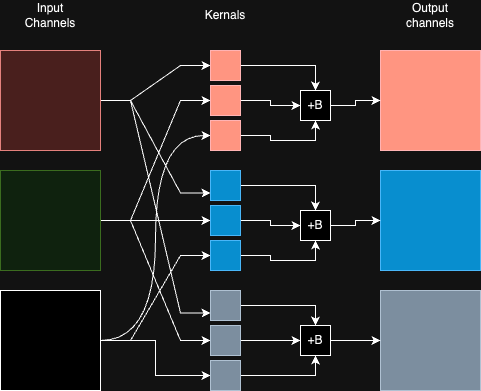

Let's say that the layer has 3 input channels, 3 output channels. Since kernals are unique for each input, output channel pair, we will require 9 kernals. 

Each kernal iterates over the its input channel, performs convolution operation at each iteration for the area it covers and produces output for the output channel. 

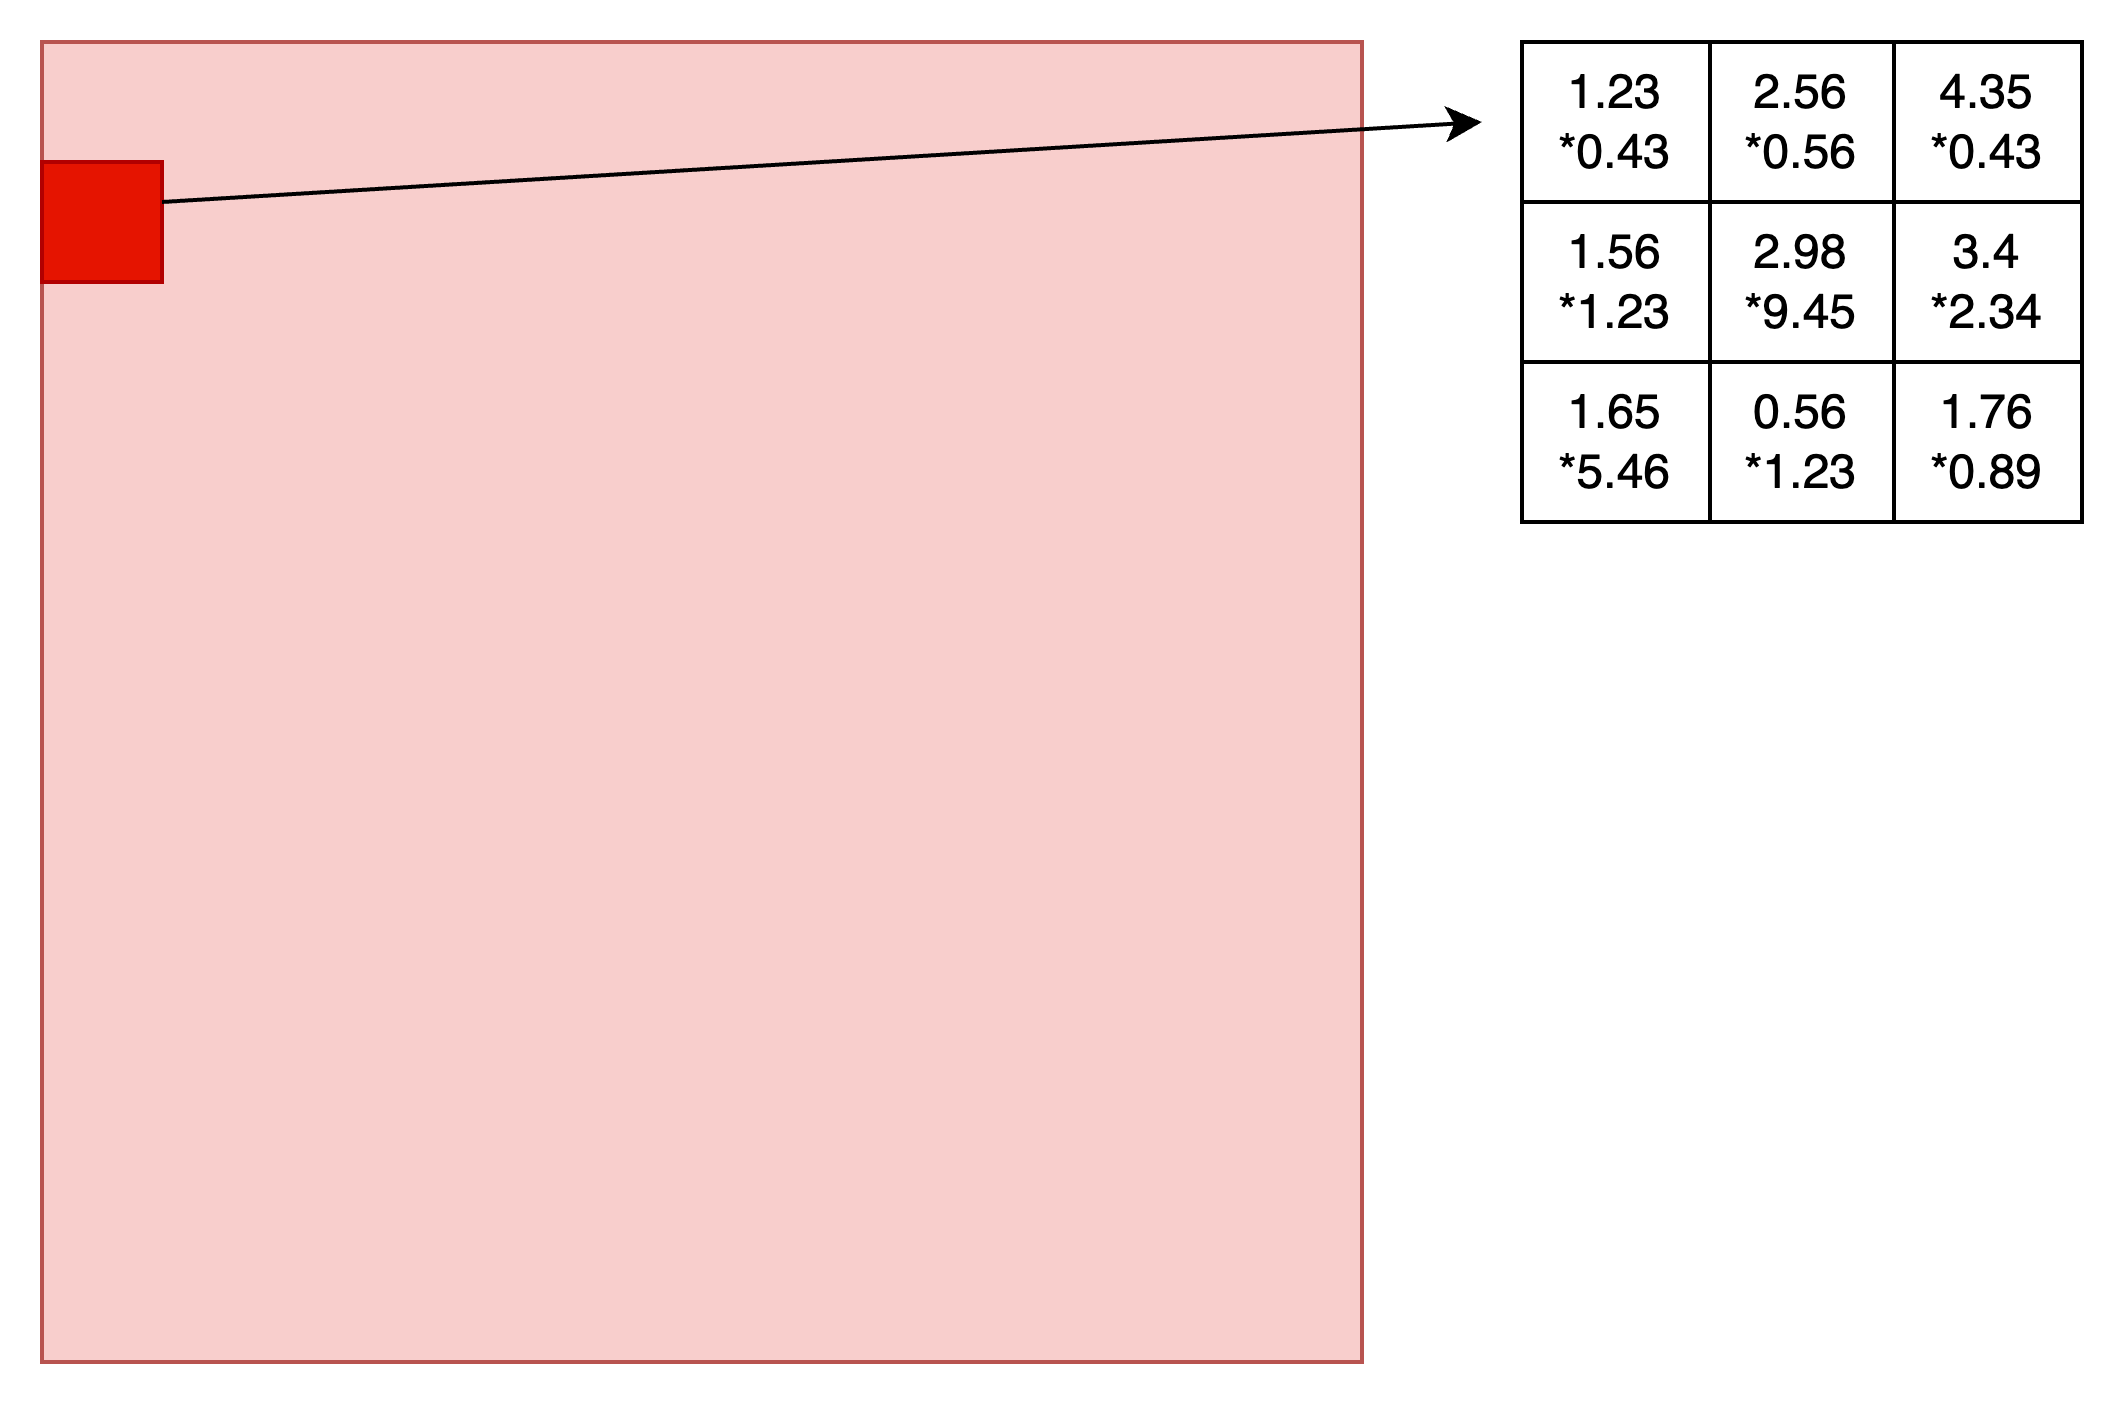

Each convolution operation is inner product of values in the kernal and the values in the area of input channel which the kernal covers at i^{th} iteration. 

I will show you how to perform convolutions and produce output channels followed by ReLU activation function by leveraging CKKS plaintext structure. 


There are several ways to write circuit to evaluate batched convolutions, ie convolution between multiple input channels and the respective kernals for a given output channel. For today we will be using the technique described my Kim et. al in "Optimized Privacy-Preserving CNN Inference With Fully Homomorphic Encryption". 

Ther are two key ideas in their technique
1. They leverage negacyclic property of multipcaition in coefficient encoding to evaluate a batched convolution specific to a output channel. 
2. They show how to re-pack CKKS plaintexts each consiting elements of different output channels at pre-determined indices into single CKKS plaintext, such that the resulting CKKS plaintext can be fed as input channel for the next layer. 

In [133]:
def negacylic_mul_monomial(a: [F], monomial_exp: int) -> [F]:
    N = len(a)

    monomial_exp = monomial_exp % (2*N)

    out = np.zeros(shape=N, dtype=F).tolist()

    for i in range(N):
        exp = (i + monomial_exp) % (2*N)
        if exp >= N:
            out[exp-N] -= a[i]
        else:
            out[exp] += a[i]
    
    return out

def pack_input_channel(w: int, k: int, input: [[F]], N: int, s: int=1) -> [F]: 
    '''
    Pack 2D input channel into a polynomial in R_{N}. 
    
    For more details refer to Theorem 1
    '''
    poly = np.zeros(shape=N, dtype=F).tolist()
    for row in range(w):
        for col in range(w):
            exponent = (row - k) * w + col
            if exponent < 0:
                exponent = N+exponent
                poly[exponent] -= input[row][col]
            else:
                poly[exponent] += input[row][col]

    return substitute_poly(poly, s=s)

def pack_kernals(w: int, k: int, kernals: [[F]], N: int, s: int=1) -> [F]: 
    poly = np.zeros(shape=N, dtype=F).tolist()
    for row in range(k):
        for col in range(k):
            exponent = (w*k)- (row*w+col)
            if exponent < 0:
                exponent = N+exponent
                poly[exponent] -= kernals[row][col]
            else:
                poly[exponent] += kernals[row][col]

    return substitute_poly(poly, s)

def encode_input_channels(input_channels:[[[F]]], w: int, k: int, B_out: int, B_in: int, N: int) -> CkksPlaintext: 
    '''
    Encodes `B_in` input channels into a single CKKS Plaintext
    '''
    assert len(input_channels) == B_in
    B = B_in
    assert max(w*w*B*B_out, k*k*B*B_out) <= N
    
    
    s = B_out
    sum_i_x = np.zeros(shape=N, dtype=F).tolist()
    for i in range(B):
        i_x = negacylic_mul_monomial(
            a=pack_input_channel(w=w, k=k, input=input_channels[i], N=N, s=s), 
            monomial_exp=i
        )

        sum_i_x = add_poly(sum_i_x, i_x)
    return CkksPlaintext.coefficient_encode(v=sum_i_x)

def encode_kernals(kernals:[[[F]]], w: int, k: int, B_out: int, B_in: int, N: int) -> np.ndarray: 
    '''
    Logic of encode_kernals and encode_input_channels is same, the difference being the packing strategies they use. 
    encode_kernals uses pack_kernal function to pack kernals as plaintext.
    '''
    assert len(kernals) == B_in
    B = B_in
    assert max(w*w*B*B_out, k*k*B*B_out) <= N
    
    s = B_out
    sum_i_x = np.zeros(shape=N, dtype=F).tolist()
    for i in range(B):
        i_x = negacylic_mul_monomial(
            a=pack_kernals(w=w, k=k, kernals=kernals[i], N=N, s=s), 
            monomial_exp=-i
        )

        sum_i_x = add_poly(sum_i_x, i_x)
    return CkksPlaintext.coefficient_encode(v=sum_i_x)


def conv3x3_S1_inplain(w: int, k: int, input: [[F]], kernel: [[F]]) -> [[F]]:
    '''
    A 3x3 convolution between Kenral and Input. 
    
    - Input must have dimension w x w
    - Kernal must have dimension 3 x 3
    '''
    assert len(kernel) == k
    assert k == 3

    out_w = w - (k - 1)
    output = [[F(0) for _ in range(out_w)] for _ in range(out_w)]


    stride = 1
    col = 0
    row = 0
    out_col = 0
    out_row = 0
    while row + (k-1) < w:
        while col + (k-1)< w: 

            tmp = output[out_row][out_col]
            for inner_r in range(k):
                for inner_c in range(k):
                    tmp += input[row+inner_r][col+inner_c] * kernel[inner_r][inner_c]

            output[out_row][out_col] = tmp

            col += stride
            out_col += 1
        
        col = 0
        out_col = 0

        row += stride
        out_row += 1

    return output

def extract_output_matrix_from_poly(poly: [F], dim: int, w: int, stride: int) -> [[F]]:
    '''
    Extracts elements of output channel at specific index into a output channel matrix
    '''
    output = [[F(0) for _ in range(dim)] for _ in range(dim)]

    for row in range(dim):
        for col in range(dim):
            output[row][col] = poly[stride*((row*w)+col)]

    return output

def add_matrices(input: [[[F]]]) -> [[F]]: 
    '''
    Adds a list of 2d sqaure matrices
    '''
    dim = len(input[0])
    how_many = len(input)
    
    # check is square
    assert dim == len(input[0][0])

    output = [[F(0) for _ in range(dim)] for _ in range(dim)]

    for row in range(dim):
        for col in range(dim):
            for z in range(how_many):
                output[row][col] += input[z][row][col]
    
    return output


In [134]:
def random_2d_matrix(dim: int) -> [[F]]:
    m = [np.random.rand(dim).tolist() for _ in range(dim)]
    return m

# Input image has dimension w x w
w = 8
# Kernal width k
k = 3

B_in = 3
B_out = 3

N = 1024

input_channels = [random_2d_matrix(w) for _ in range(B_in)]

# kernals for output channel 0 
kernal_0 = [random_2d_matrix(k) for _ in range(B_in)]

# Let's evaluate Batch convolution between Kernals of output channel 0 and input channels. 

# We encode all input channels into a single CKKS plaintext
i_x = encode_input_channels(input_channels=input_channels, B_in=B_in, B_out=B_out, k=k, N=N, w=w)
# We encode kernals for output channel 0 as another CKKS plaintext
k_x_0 = encode_kernals(kernals=kernal_0, B_in=B_in, B_out=B_out, k=k, N=N, w=w)

# Multiplication of I(X) and K_0(X) outputs O_0(X) that holds elements of output channel 0 at pre-determined indices
o_x_0 = i_x * k_x_0

# Let's verify whether the convolution is correct

# Convolution in plain
output_0_pieces = []
for (ic, kc) in zip(input_channels, kernal_0):
    output_0_pieces.append(conv3x3_S1_inplain(w=w, k=k, input=ic,kernel=kc))
want_output_0 = add_matrices(output_0_pieces)

# Elements of output channel 0 are present at specific indices. Let's extract them. 
have_output_0 = extract_output_matrix_from_poly(poly=o_x_0.decode(), dim=len(want_output_0),stride=B_out, w=w)

print("#### Batch convolution Kernal 0 - Output Channel 0 ####")
for (index, (h0, w0)) in enumerate(zip(have_output_0, want_output_0)):
    print(f'Row {index}')
    precision_stats(wants=w0, values=h0)
print("######################################################")


#### Batch convolution Kernal 0 - Output Channel 0 ####
Row 0

     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [7.371529540179168, 6.967531943998421, 7.716839641864119]
        Wants   : [7.371529540179168, 6.967531943998422, 7.716839641864119]

        Max : inf
        Mean: inf
        
    
Row 1

     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [6.353076428912416, 6.8618442956242065, 7.242939276188139]
        Wants   : [6.353076428912416, 6.861844295624207, 7.242939276188139]

        Max : inf
        Mean: inf
        
    
Row 2

     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [5.745737680574025, 6.422354379034738, 5.3155257930688835]
        Wants   : [5.745737680574025, 6.422354379034737, 5.315525793068884]

        Max : inf
        Mean: inf
        
    
Row 3

     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [6.580866723280946, 7.623858692

/var/folders/0j/nn6_632s7b7bwdg71rbtjpcr0000gn/T/ipykernel_10933/4294523121.py:63: RuntimeWarning: divide by zero encountered in log2
  logdiff = -np.log2(abs(diff))


We were able to perform batch convolution between input channels and kernals of output channel 0 as CkksPlaintexts using just a single multiplication by leveraging **negacylic property coefficient encoding**.

Let's calculate batch convolution for the rest of the output channels.

In [135]:
# Batch convolution for output channel 1, 2
kernal_1 = [random_2d_matrix(k) for _ in range(B_in)]
kernal_2 = [random_2d_matrix(k) for _ in range(B_in)]

k_x_1 = encode_kernals(kernals=kernal_1, B_in=B_in, B_out=B_out, k=k, N=N, w=w)
k_x_2 = encode_kernals(kernals=kernal_2, B_in=B_in, B_out=B_out, k=k, N=N, w=w)

o_x_1 = i_x * k_x_1
o_x_2 = i_x * k_x_2

Now we have 3 CKKS plaintexts that hold elements of output channels at pre-determined indices. We're left with a way to evaluate ReLU activation function on each of the elements. 

But as you will notice the output channels are in 3 different CKKS plaintexts, and it will be nice if we can pack them into a single plaintext s.t. it can fed as input to the next layer. However, for today, I wouldn't discuss this. The technique for packing requires a bunch of rotations and additions (no multiplications) and is standard procedure. I would want tell you something more interesting - How does one evaluate a non-linear function like ReLU (i.e. f(x) = max(0, x)) using CkksPlaintext that only has access to addtion, subtraction, and multiplication?

## Evaluate ReLU

The general technique to evaluate non-linear functions, like ReLU, is to give up exact evaluation and instead approximate them using some polynomial. Hence, we approximate ReLU using a polynomial. 

This highlights an inherent trade-off in evaluating non-linear functions like ReLU in CKKS. Intuitively, a lower degree polynomial approximation will incur less latency (because less multiplications) but will degrade output accuracy. On other hand, a high degree polynomial approximation will output results with mininmal error but will require higher latency.

However, we cannot directly evaluate a polynomial over ckks plaintexts consisting output channel elements. This is because the elements are in coefficient encoding not in SIMD encoding and we want to evaluate the polynomial on each element individually, not on the plaintext. Thus, we will have to switch the encoding from coefficient to SIMD homomorphically.



### Switch from Coefficient to SIMD encoding 



In [136]:
def combine_r_matrix_vectors(input_matrix_vectors: [dict[int:np.ndarray]], r:int, logN:int):
    '''
        Combines input diagonal matrices into groups of r

        - input_matrix_vectors: Array of matrices represented via diagonal vectors stored in a dict where key denotes the diagonal
        - outputs `input_matrix_vectors/r` collection of matrices
    '''
    assert logN-1 == len(input_matrix_vectors)

    out = []

    N_half = 1<<(logN-1)

    # combine r matrix vectors together
    for i in range(0, logN-1, r):
        ith_combined_v0_matrix = {}

        for key in input_matrix_vectors[i].keys():
            ith_combined_v0_matrix[key] = input_matrix_vectors[i][key]
            
        
        for j in range(i+1, i+r, 1):
            ith_combined_v0_matrix_copy = {}

            for k0 in ith_combined_v0_matrix.keys():
                for k1 in input_matrix_vectors[j].keys():
                    tmp = ith_combined_v0_matrix[k0] * input_matrix_vectors[j][k1]
                    out_k = (k0 + k1)%N_half

                    print(out_k)
                    if out_k in ith_combined_v0_matrix_copy:
                        ith_combined_v0_matrix_copy[out_k] += tmp
                    else:
                        ith_combined_v0_matrix_copy[out_k] = tmp
                        
                
            ith_combined_v0_matrix = copy.deepcopy(ith_combined_v0_matrix_copy)
                
        out.append(ith_combined_v0_matrix)
    return out



def v0_decomposition_vectors(logN: int, r: int) -> ([dict[int: np.ndarray]], [dict[int: np.ndarray]]):
    '''
    Returns decomposed matrices of v0 & v0^{-1} as collectiion of diagonal vectors corresponding to non-zero indices. 
    
    For more information refer to section 4.2 of https://eprint.iacr.org/2018/1073.pdf
    
    # Warning
    When r >= 2, the decomposition fails. Will fix this later.
    '''

    assert (logN-1) % r == 0, "r must divide N_half"

    N = 1 << logN
    N_half = 1 << (logN - 1)
    curr_i = 1

    # E_2 * E_4 * ... E_{N/2}
    v0_matrices = []
    v0_inv_matrices = []

    while curr_i <= logN - 1 :
        #  (N/2)/2^i
        curr_N = N_half >> curr_i

        m = {
            0: np.zeros((N_half), dtype=Comp),
            curr_N: np.zeros((N_half), dtype=Comp),
            N_half-curr_N: np.zeros((N_half), dtype=Comp)
        }
        m_inv = {
            0: np.zeros((N_half), dtype=Comp),
            curr_N: np.zeros((N_half), dtype=Comp),
            N_half-curr_N: np.zeros((N_half), dtype=Comp)
        }
        

        
        psi = find_mth_root_of_unity(M= curr_N*4)
        psi_powers = [psi ** (5 ** i) for i in range(curr_N)]
        # print(curr_N, psi, psi_powers)
        
        # 0th diagonal
        curr_step = 0 
        flag = True
        row_col = 0
        while row_col < N_half:
            if flag:
                m_inv[0][row_col] = 1
                m[0][row_col] = 1
            else:
                m_inv[0][row_col] = np.conjugate(-1 * psi_powers[curr_step])
                m[0][row_col] = -1 * psi_powers[curr_step]

            row_col += 1
            curr_step += 1

            if curr_step == curr_N:
                curr_step = 0
                flag = not flag
        
        # +(N/2)/2^i
        row = 0
        col = curr_N
        flag = True
        curr_step = 0 
        while row < N_half:
            if flag:
                m_inv[curr_N][row] = 1
                m[curr_N][row] = psi_powers[curr_step]
            else:
                pass

            row += 1
            col += 1
            curr_step += 1

            if curr_step == curr_N:
                curr_step = 0
                flag = not flag


        # -(N/2)/2^i
        row = 0
        col = N_half-curr_N
        flag = False
        curr_step = 0 
        while row < N_half:
            if flag:
                m_inv[N_half-curr_N][row] = np.conjugate(psi_powers[curr_step])
                m[N_half-curr_N][row] = 1
                # print(m[row][col%N])
            else:
                pass

            row += 1
            col += 1
            curr_step += 1

            if curr_step == curr_N:
                curr_step = 0
                flag = not flag
            
        if curr_i == logN-1:
            for i in m_inv:
                m_inv[i] = (2*m_inv[i]) / (1 << logN)


        # print(np.conjugate(m).transpose() - m_inv)
        # print()
        # print()
        v0_inv_matrices.append(m_inv)
        v0_matrices.append(m)

        curr_i += 1

    v0_matrices = combine_r_matrix_vectors(v0_matrices, r=r, logN=logN)
    # v0_inv_matrices.reverse()
    v0_inv_matrices = combine_r_matrix_vectors(v0_inv_matrices, r=r, logN=logN)
    # v0_inv_matrices.reverse()


    return (v0_matrices ,v0_inv_matrices)


def coeff_to_slots(t: CkksPlaintext) -> (CkksPlaintext, CkksPlaintext):
    '''
    Puts coefficients of message m, encoded as coefficients, into SIMD slots. 
    
    Returns two plaintexts. The first contains upper half coefficients of m encoded in SIMD slots. The 
    second contains lower half cofficients of m encoded in SIMD slots.
    '''
    assert t.encoding == Encoding.COEFFICIENT
    
    logN = int(math.log2(len(t.coeffs)))
    N = 1 << logN
    N_half = 1 << (logN - 1)
    M = 1 << (logN+1)

    r = 1 # TODO: It fails when r >= 2
    (_, v0_inv_decomp_vectors) = v0_decomposition_vectors(logN=logN, r=r)

    # print(len(v0_inv_decomp_vectors),v0_inv_decomp_vectors[0],"\n",  v0_inv_decomp_vectors[1])
    
    
    # V0^{-1} * z
    v0_inv_z = CkksPlaintext(coeffs=np.copy(t.coeffs), encoding=Encoding.SIMD) # change encoding to SIMD to make assert happy
    for i in range(1, logN, r):

        # generate set of rotations
        sets = set({0, N_half >> i, N_half-(N_half>>i)})
        for k in range(i+1, i+r):
            sets_copy = set()
            for s in sets:
                for v in [0, N_half>>k, N_half-(N_half>>k)]:
                    sets_copy.add((s + v)%N_half)
            sets = copy.deepcopy(sets_copy)


        out = None

        index = i//r
        if r == 1:
            index -= 1 

        for rot in sets:
            tmp = None
            if rot == 0:
                vect = CkksPlaintext.simd_encode_complex(v=v0_inv_decomp_vectors[index][rot].tolist())
                tmp = v0_inv_z * vect
            else:
                vect = CkksPlaintext.simd_encode_complex(v=v0_inv_decomp_vectors[index][rot].tolist())
                tmp = v0_inv_z.rotate(rot) * vect

            if out is None:
                out = tmp
            else:
                out += tmp

        v0_inv_z = out

    # print(v0_inv_z)

    # t0 = 0.5 (v^-1 z + \bar{v^{-1} z}) - SIMD slots of upper half coefficients 
    # t1 = -0.5i (v^-1 z - \bar{v^{-1} z}) - SIMD slots of lower half coefficients
    v0_inv_z_conj = v0_inv_z.conjugate()
    half_constant = CkksPlaintext.simd_encode_complex(v=[Comp(0.5) for _ in range(N_half)])
    negi_half_constant = CkksPlaintext.simd_encode_complex(v=[Comp(0.0 - 0.5j) for _ in range(N_half)])
    t0 = (v0_inv_z + v0_inv_z_conj) * half_constant
    t1 = (v0_inv_z - v0_inv_z_conj) * negi_half_constant
    
    return (t0, t1)

def slots_to_coeff(t0: CkksPlaintext, t1:CkksPlaintext) -> CkksPlaintext:
    assert t0.encoding == Encoding.SIMD
    assert t1.encoding == Encoding.SIMD
    
    logN = int(math.log2(len(t0.coeffs)))
    N = 1 << logN
    N_half = 1 << (logN - 1)
    M = 1 << (logN+1)

    r = 1 # TODO: It fails with when r >= 2
    (v0_decomp_vectors, _) = v0_decomposition_vectors(logN=logN, r=r)
    
    
    i_constant = CkksPlaintext.simd_encode([Comp(0.0+ 1j) for _ in range(N_half)])
    t_back = t0 + t1*i_constant
    for i in range(logN-1, 0, -r):

        # generate set of rotations
        sets = set({0, N_half >> i, N_half-(N_half>>i)})
        for k in range(i-1, i-r, -1):
            sets_copy = set()
            for s in sets:
                for v in [0, N_half>>k, N_half-(N_half>>k)]:
                    sets_copy.add((s + v)%N_half)
            sets = copy.deepcopy(sets_copy)

        out = None

        for rot in sets:
            tmp = None
            if rot == 0:
                vec = CkksPlaintext.simd_encode_complex(v=v0_decomp_vectors[i//r-1][rot].tolist())
                tmp = t_back * vec
            else:
                vec = CkksPlaintext.simd_encode_complex(v=v0_decomp_vectors[i//r-1][rot].tolist())
                tmp = t_back.rotate(by=rot) * vec

            if out is None:
                out = tmp
            else:
                out += tmp

        t_back = out
    
    t_back = CkksPlaintext(coeffs=t_back.coeffs, encoding=Encoding.COEFFICIENT)
    return t_back

In [138]:
m = [F(np.random.rand()) for _ in range(16)]
m_pt = CkksPlaintext.coefficient_encode(v=m)

# m_upper_simd contains upper of half of message m in SIMD slots
# m_lower_simd contains lower of half of message m in SIMD slots
m_upper_simd, m_lower_simd = coeff_to_slots(t=m_pt)
assert m_lower_simd.encoding == Encoding.SIMD
assert m_upper_simd.encoding == Encoding.SIMD

# Let's put the slots back into coefficients and check whether we get m back
m_pt_back = slots_to_coeff(t0=m_upper_simd, t1=m_lower_simd)
precision_stats(values=m_pt_back.decode(), wants=m)



     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [0.9969438074809239, 0.458434260158049, 0.9311847810491405]
        Wants   : [0.9969438074809264, 0.4584342601580489, 0.9311847810491442]

        Max : 53.0
        Mean: 49.08058618535492
        
    


One key thing to note about plaintexts containing upper/lower coefficients in SIMD slots is they assume that same function will be evaluated on all the slots and hence don't counter the fact that order is reversed in FFT. So one can only evaluate a single function all coefficients.

For ex, 

Multiplying all coefficients by 12 is ok

In [140]:
m1 = [F(12) for _ in range(8)]
m1_pt = CkksPlaintext.simd_encode(m1)
m1_m_upper_simd = m_upper_simd * m1_pt
m1_m_lower_simd = m_lower_simd * m1_pt

m1_m_pt_back = slots_to_coeff(t0=m1_m_upper_simd, t1=m1_m_lower_simd)
# Upper half of m0 x m1 | Lower half of m0 x m1
m1_m_want = [a*b for (a,b) in zip(m[:8], m1)] + [a*b for (a,b) in zip(m[8:], m1)] 
precision_stats(values=m1_m_pt_back.decode(), wants=m1_m_want)


     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [11.96332568977109, 5.501211121896592, 11.174217372589688]
        Wants   : [11.963325689771116, 5.501211121896587, 11.17421737258973]

        Max : 47.415037499278846
        Mean: 45.37971771428662
        
    


But multiplying coefficients with a random vector consisting different value in different slots is not.

In [141]:
m1 = [np.random.rand() for _ in range(8)]
m1_pt = CkksPlaintext.simd_encode(m1)
m1_m_upper_simd = m_upper_simd * m1_pt
m1_m_lower_simd = m_lower_simd * m1_pt


m1_m_pt_back = slots_to_coeff(t0=m1_m_upper_simd, t1=m1_m_lower_simd)
# Upper half of m0 x m1 | Lower half of m0 x m1
m1_m_want = [a*b for (a,b) in zip(m[:8], m1)] + [a*b for (a,b) in zip(m[8:], m1)] 
precision_stats(values=m1_m_pt_back.decode(), wants=m1_m_want)


     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [0.63256129036124, -0.00825100891470687, 0.6897570260153167]
        Wants   : [0.6325612903612414, 0.2323928525354382, 0.0856151530273017]

        Max : 49.29956028185891
        Mean: 8.625475294738763
        
    


## Approximating ReLU with polynomial

There are several ways to evaluate ReLU with varying range of accuracy and I will just show you one of them.

Let there be a sign function sign(x). Sign function returns +1 if x is + or 0, otherwise -1. Then we can write ReLU(x) as:

$$ReLU(x) = \frac{x + x*sign(x)}{2}$$

We approximate the sign function using the polynomial:

$$sign(x) \approx f3(f2(f1(x)))$$

where

$$f1(x) = 10.8541842577442x − 62.2833925211098x^3 + 114.369227820443x^5 − 62.8023496973074x^7$$
$$f2(x) = 4.13976170985111x − 5.84997640211679x^3 + 2.94376255659280x^5 − 0.454530437460152x^7$$
$$f3(x) = 3.29956739043733x − 7.84227260291355x^3 + 12.8907764115564x^5 − 12.4917112584486x^7 + 6.94167991428074x^9  − 2.04298067399942x^{11} + 0.246407138926031x^{13}$$

The approximation has 10 bits of precision for input $x \in [-1, 1]$, that is error is bounded by 2^{-10}.


Then, 

$$ReLU(x) \approx \frac{x + x * f3(f2(f1(x)))}{2}$$


However, in practice $x$ can be outside the range of $[-1, 1]$. So instead we experimentally figure out the range $[-B, B]$ for x, then scale the input by $1/B$, evaluate the polynomial approximation of ReLU for range $[-1, 1]$, and scale the output back to $[-B, B]$.

But this has the effect to scaling the error of ReLU by $B$. So if the original error for input range $[-1, 1]$ is $2^{-10}$, then the error of the output of RelU on input range $[-B, B]$ will be $B*2^{-10}$. 

$$ReLU'(x) = B * ReLU(x/B)$$

where input $x \in [-B, B]$ and error is bounded by $B*2^{-\alpha}$ where $2^{-\alpha}$ is error of ReLU().



In [194]:
def sign(x: CkksPlaintext) -> CkksPlaintext:
    N = 1<<int(math.log2(len(x.coeffs)))
    N_half = N//2
    
#     print("x: ", x.decode())
    
    # f1
    x_2 = x*x
    x_3 = x_2*x
    x_5 = x_2*x_3
    x_7 = x_2*x_5    
    f1 = (CkksPlaintext.simd_encode_broadcast(v=F(10.8541842577442), vec_size=N_half) * x) - (CkksPlaintext.simd_encode_broadcast(v=F(62.2833925211098), vec_size=N_half) * x_3) + (CkksPlaintext.simd_encode_broadcast(v=F(114.369227820443), vec_size=N_half) * x_5) - (CkksPlaintext.simd_encode_broadcast(v=F(62.8023496973074), vec_size=N_half) * x_7)  
    
#     print("f1: ", f1.decode())
    
    # f2(f1(x))
    x = f1
    x_2 = x*x
    x_3 = x_2*x
    x_5 = x_2*x_3
    x_7 = x_2*x_5
    f2 = (CkksPlaintext.simd_encode_broadcast(v=F(4.13976170985111), vec_size=N_half) * x) - (CkksPlaintext.simd_encode_broadcast(v=F(5.84997640211679), vec_size=N_half) * x_3) + (CkksPlaintext.simd_encode_broadcast(v=F(2.94376255659280), vec_size=N_half) * x_5) - (CkksPlaintext.simd_encode_broadcast(v=F(0.454530437460152), vec_size=N_half) * x_7)  
    
#     print("f2: ", f2.decode())
    
    # f3(f2(f1(x)))
    x = f2
    x_2 = x*x
    x_3 = x_2*x
    x_5 = x_2*x_3
    x_7 = x_2*x_5
    x_9 = x_2*x_7
    x_11 = x_2*x_9
    x_13 = x_2*x_11
    f3 = (CkksPlaintext.simd_encode_broadcast(v=F(3.29956739043733), vec_size=N_half) * x) - (CkksPlaintext.simd_encode_broadcast(v=F(7.84227260291355), vec_size=N_half) * x_3) + (CkksPlaintext.simd_encode_broadcast(v=F(12.8907764115564), vec_size=N_half) * x_5) - (CkksPlaintext.simd_encode_broadcast(v=F(12.4917112584486), vec_size=N_half) * x_7) + (CkksPlaintext.simd_encode_broadcast(v=F(6.94167991428074), vec_size=N_half) * x_9) - (CkksPlaintext.simd_encode_broadcast(v=F(2.04298067399942), vec_size=N_half) * x_11) + (CkksPlaintext.simd_encode_broadcast(v=F(0.246407138926031), vec_size=N_half) * x_13)
    
#     print("f3: ", f3.decode())
    
    return f3

def ReLU(x: CkksPlaintext, B: int) -> CkksPlaintext:
    '''
    Return approximation ReLU(x) where x must be in range [-B, B]. Error of output is bounded by B*2^{-10}.
    '''
    N = 1 << int(math.log2(len(x.coeffs)))
    N_half = N//2

    # 1/B * x
    x_scaled = CkksPlaintext.simd_encode_broadcast(v=F(1/B), vec_size=N_half) * x
    
    # (x + x * sign(x)) / 2
    sign_x = sign(x=x_scaled)
    tmp = x_scaled + (x_scaled * sign_x)
    half = CkksPlaintext.simd_encode_broadcast(v=F(1/2), vec_size=N_half)
    relu_x = tmp * half
    
#     print("sign(x) ", sign_x.decode())
#     print("relu(x) [-1,1]", relu_x.decode())
#     print(x.decode())
    
    # scale back to interval [-B, B]
    relu_x = CkksPlaintext.simd_encode_broadcast(v=F(B), vec_size=N_half) * relu_x
    
    return relu_x
    
    

In [195]:
B = 25
m = [F(np.random.randint(-B, B)) for _ in range(8)]
pt_m = CkksPlaintext.simd_encode(v=m)

relu_m_back = ReLU(x=pt_m, B=B)
relu_m_want = [max(F(0), i) for i in m]
precision_stats(values=relu_m_back.decode(), wants=relu_m_want)


     ---------------
    |PRECISION STATS|
     ---------------
        Values  : [-0.016585405283082482, 21.98341459471683, 0.00489092730240215]
        Wants   : [0.0, 22.0, 0.0]

        Max : 11.453677392575445
        Mean: 7.738791523284606
        
    


SIMD encoding: 

With SIMD encoding you can store a vector of real numbers inside the plaintext. Such that all operations are peformed in SIMD way (i.e. elwise). SIMD also allows one to do rotations (tell more about rotations)

(Show how encoding works)
(Show a bunch of examples)

Now we know how to evaluate a single layer of convolution, such that we end up with a polynomial that can be fed as input channel to the next convolution layer. 

But we are missing 1 crucial operation that happens on each element of output channels before the next layer ~ Actication function! 

Let's assume that our activation function is ReLU (not a bad assumption, since it is one of the most widely used ones). ReLU is evaluated on each element of output channels. This implies we need to evaluate ReLU function on each coefficient of the output polynomial. 


But there's a problem. ReLU is a non-linear function! (i.e. x = max(0, x)). How can one evaluate a non-linear function with only access to additions,multiplications, and rotations? 

One cannot evaluate ReLU exactly and instead need to approximate using Polynomial approximation. This highlights one tradeoff in evaluating CNNs (or NNs in general) using CKKS. Intuitively, a less accuracte approximation will degrade the output of inference, but will require a low degree polynomial. On the other hand, to improve inerence accuracy one can use higher degree polynomial approximation at the cost of higher runtime 


There are many polynomial approximatino techniques. Moreover, there have been attempts to re-train models by replacing ReLU (or other non-linear actication functions) with polynomial activation functions. So that one can have higher inference accuracy and low latency. Surprisingly, the re-trained model with polynomial actication functions don't lose much performance. However, re-training is expensive and we would want to avoid that. Which is why for today, we will focus on polynomial approximatino of ReLU function instead. 


Again one can use any other polynomial approximation tehcnique. But we will use this techqnie from this paper. 

The following function shows how to evaluate sing function on the input with just 10 multiplications -


Then one can use the sign function evaluate the ReLU functiona s follows:


The paper shows that for input in inteveral [-1, 1] the output is \alpha accuracy. But our input can be in arbitrary range. So we first experimentally determine what's maximum range [-B, B]. Then to evaluate the function
1. we scale out input by 1/B
2. evaluate the function
3. rescale it back to range [-B, B] by multiplying by B




In [17]:
# 1. Let's assume that the input is in range - [-B, B]
# 2. Show polynomial approximation and evaluate the function
# 3. Show the error accumulate

There's just one last prorlbem to solve before we can evaluate ReLU function on each coefficient of the output polynomial. That is, the ReLU function needs to applied to each coefficient as a scalar instead of a polynomial. We need a way to transform plaintext from coefficient encding to simd encoding because it is only in SIMD encoding we can apply ReLU function to each coefficient independently. 

So how can we transform coefficient encoding to SIMD encoding. For doing so we will make the following observtion:

Making the observation reveals that if we can apply these transformations homomrphically we can convert from coefficient to SIMD encoding. 

How do we apply the transformations? 

1. Naive way: Matrix vector multiplication. Runtime is n^2. In practice n is big, and hence takes really long. There exists a better way that simulates FFT homomprhically. 
2. FFT way. 


In [19]:
# naive way Coeff to slot

In [ ]:
# FFT way to coeff to slot

In [ ]:
# Inverse of coeff to slot